In [1]:
# importing all libraries needed
import numpy as np
import pandas as pd
import os
import time
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from itertools import combinations
import matplotlib.pyplot as plt # importing matplotlib
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
import statistics

In [2]:
#Stanting timming process
start = time.time()

In [3]:
# saving the main directory
main_directory = os.getcwd()

In [4]:
# subfolder_name = [f.name for f in os.scandir(main_directory) if f.is_dir()]
subfolder_with_path = ["" for i in range(4)]
subfolder_with_path[0] = main_directory + '/'+'01Activity_files'
subfolder_with_path[1] = main_directory + '/'+'02Volume_files'
subfolder_with_path[2] = main_directory + '/'+'03Volume_in_tissue_files'
subfolder_with_path[3] = main_directory + '/'+'zzz_input_and_reference_files'

In [5]:
###############################################################################################
# Importing information from "samples overview", "intensisties template" and "brain allen map"
###############################################################################################

# Changing directory to the "zzz_input_and_reference_files" folder
os.chdir(subfolder_with_path[-1])


# Reading "sample_overview.csv" file
samples_overview = pd.read_csv("sample_overview.csv", 
                               dtype={"MOUSE": "string","SAMPLE": int,
                                      "FILES_HD": int,"FILES_BOX": int,
                                      "hemisphere": "string","MARKER": "string",
                                      "TX_GROUP": "string", 
                                      "GENDER":"string", 
                                      "CONTEXT":"string"})

# Reading "gubra_intensities_template.csv" file
gubra_intensities_template = pd.read_csv("gubra_intensities_template.csv",
                                   dtype={"IDPath": "string", 
                                          "LabelID": int, 
                                          "raw": "string", 
                                          "LabelAbrv": "string"})
# Reading "brain_allen_map.csv" file
brain_gubra_map = pd.read_csv("brain_gubra_map_fixed.csv", 
                               dtype={"IDPath": "string", "LabelAbrv": "string",
                                      "raw": "string","allen_1": "string",
                                      "allen_2": "string","allen_3": "string",
                                      "allen_4": "string","allen_5": "string",
                                      "allen_6": "string","allen_7": "string",
                                      "fine": "string","medium": "string",
                                      "coarse": "string", "all":"string"})


In [6]:
#Saving drugs and markers' names from the "sample_overview" file

drugs = samples_overview['TX_GROUP'].unique()
markers = samples_overview['marker'].unique()

d = 0
m = 0
counters_names = []
while (m < len(markers)):
    while (d < len(drugs)):
        counters_names.append(drugs[d] + '_' + markers[m])
        d += 1
    m += 1
    d = 0

In [7]:
# Changing directory to the "02Volume_files" folder
os.chdir(subfolder_with_path[1])

#Counting number of files on "02Volume_files" folder
list = os.listdir(subfolder_with_path[1]) 
number_files = len(list)
number_volume_files = number_files

In [8]:
#Using and timing  a loop to process all files and populate the main data-frame

volume_data = [] #This array will contain df as elements

i = 0
while i < number_files:

    ##############################################
    # Processing each file
    ##############################################
    
    file = list[i]
    # Saving sample's number
    filename_segmented = file.split('_')
    sample = filename_segmented[1]


    # Reading file's data
    header = ["PIXEL_COUNT"]
    pixels_count_volume = pd.read_csv(file, names = header)
    pixels_count_volume.insert(0, column = 'INTENSITY', value = range(0, len(pixels_count_volume))) 

    # Adding activity columns to intensitites template data-frame
    output = gubra_intensities_template.merge(pixels_count_volume, how='left', left_on='LabelID', right_on='INTENSITY')
    output = output.drop(columns=['INTENSITY'])
    volume_label_name = 'VOLUME'
    output = output.rename(columns = {'PIXEL_COUNT':volume_label_name})
    output['VOLUME'] = output['VOLUME'].div(1000000).round(7)
    
    # Checking to which hemisphere the sample belongs to and erasing activity that belong to the other hemisphere
    hemisphere = samples_overview['hemisphere'].loc[samples_overview['SAMPLE'] == int(sample)]
    hemisphere = hemisphere.array
    if hemisphere[0] == 'left':
        output = output[output['LabelID'] > 20000]
    else:
        output = output[output['LabelID'] < 20000]
   

    # Adding a column of the sample number
    sample_column = np.empty(len(output))
    sample = int(sample)
    sample_column.fill(sample)
    output['SAMPLE'] = sample_column
    
    # Erasing the hemisphere label form the "raw" and the and "labelabrv" columns
    output["raw"] = output["raw"].str.replace('left_','')
    output["raw"] = output["raw"].str.replace('right_','')
    output["LabelAbrv"] = output["LabelAbrv"].str.replace('L','',1)
    output["LabelAbrv"] = output["LabelAbrv"].str.replace('R','',1)
    
    ##########################################################################################################################
    
    # store DataFrame in list
    volume_data.append(output)
    
    i += 1
    
#Joinning all elements of the array in a dataframe
volume_data = pd.concat(volume_data)

In [9]:
# Changing directory to the "03Volume_in_tissue_files" folder
os.chdir(subfolder_with_path[2])

#Counting number of files on "03Volume_in_tissue_files" folder
list = os.listdir(subfolder_with_path[2]) 
number_files = len(list)
number_volintissue_files = number_files

In [10]:
#Using and timing  a loop to process all files and populate the main data-frame

volume_intissue_data = [] #This array will contain df as elements

#Staring counters

i = 0 #General loop counter


#Zeroing the counters 
counters = np.zeros(len(counters_names))

#Creating counters array to contain sample's names as elements
counters_samples = [[] for j in range(len(counters_names))]

    ##############################################
    # Processing each file
    ##############################################

while i < number_files:


    file = list[i]
    # Saving sample's number 
    filename_segmented = file.split('_')
    sample = filename_segmented[1]

    # Reading file's data
    header = ["PIXEL_COUNT"]
    pixels_count_volume = pd.read_csv(file, names = header)
    pixels_count_volume.insert(0, column = 'INTENSITY', value = range(0, len(pixels_count_volume))) 

    # Adding activity columns to intensitites template data-frame
    output = gubra_intensities_template.merge(pixels_count_volume, how='left', left_on='LabelID', right_on='INTENSITY')
    output = output.drop(columns=['INTENSITY'])
    volume_label_name = 'VOLUME_IN_TISSUE'
    output = output.rename(columns = {'PIXEL_COUNT':volume_label_name})
    output['VOLUME_IN_TISSUE'] = output['VOLUME_IN_TISSUE'].div(1000000).round(6)
    
    # Checking to which hemisphere the sample belongs to and erasing activity that belong to the other hemisphere
    hemisphere = samples_overview['hemisphere'].loc[samples_overview['SAMPLE'] == int(sample)]
    hemisphere = hemisphere.array
    if hemisphere[0] == 'left':
        output = output[output['LabelID'] > 20000]
    else:
        output = output[output['LabelID'] < 20000]

    # Adding a column of the sample number
    sample_column = np.empty(len(output))
    sample = int(sample)
    sample_column.fill(sample)
    output['SAMPLE'] = sample_column
    
    # Merging activity and sample overview data-frames
    output= pd.merge(output,samples_overview[['SAMPLE',
                                             'hemisphere','marker',
                                             'TX_GROUP']],on='SAMPLE',how='inner')
    
    #Adding a column with the sample's nickname

    counters_index = counters_names.index(output['TX_GROUP'].iloc[0] + '_' + output['marker'].iloc[0])
    if output['SAMPLE'].iloc[0] not in counters_samples[counters_index]:
        counters[counters_index] += 1
        counters_samples[counters_index].append(output['SAMPLE'].iloc[0])
        nickname = 'v' + output['TX_GROUP'].iloc[0] + '_' + str(int(counters[counters_index]))

    nickname_column = np.empty(len(output))    
    output['nickname'] = nickname_column
    output['nickname'] = nickname
    
    # Erasing the hemisphere label form the "raw" and the and "labelabrv" columns
    output["raw"] = output["raw"].str.replace('left_','')
    output["raw"] = output["raw"].str.replace('right_','')
    output["LabelAbrv"] = output["LabelAbrv"].str.replace('L','',1)
    output["LabelAbrv"] = output["LabelAbrv"].str.replace('R','',1)
    
    ##########################################################################################################################
    
    # store DataFrame in list
    volume_intissue_data.append(output)
    
    i += 1
    
#Joinning all elements of the array in a dataframeo
volume_intissue_data = pd.concat(volume_intissue_data)

In [11]:
#calculating volume ratio
volumes_data = pd.merge(volume_intissue_data,volume_data[['raw','VOLUME','SAMPLE']],on=('raw','SAMPLE'),how='left')
volumes_data['volumes_ratio'] = volumes_data['VOLUME_IN_TISSUE'] / volumes_data['VOLUME'] 

In [12]:
#Pivoting dataframe to have nicknames as columns
pivoted_volumes_data = pd.pivot_table(volumes_data, values='VOLUME_IN_TISSUE', 
                                       index=['raw'],columns=['nickname'], aggfunc=np.sum)

In [13]:
# Changing directory to the "01Activity_files" folder
os.chdir(subfolder_with_path[0])

#Counting number of files on "01Activity_files" folder
list = os.listdir(subfolder_with_path[0]) 
number_files = len(list)
number_activity_files = number_files

In [14]:
#Using and timing  a loop to process all files and populate the main data-frame

activity_data = [] #This array will contain df as elements

# Extractiing pixel information
pixel_data = [] #This array will contain df as elements

#Starting counters

i = 0 #General loop counter

#Zeroing the counters 
counters = np.zeros(len(counters_names))

#Creating counters array to contain sample's names as elements
counters_samples = [[] for j in range(len(counters_names))]


    ##############################################
    # Innitiates loop to process each file
    ##############################################


while i < number_files:

    # Working with each file at a time
    file = list[i]
    
    # Saving sample's number
    filename_segmented = file.split('_')
    sample = filename_segmented[1]

    # Reading file's data
    regions_count_activity_fracc = pd.read_csv(file,low_memory=False)
    #Cleanning row that have the srting "PIXEL_COUNT" instead of values
    regions_count_activity_fracc = regions_count_activity_fracc[regions_count_activity_fracc.PIXEL_COUNT != "PIXEL_COUNT"] 
    #Filtering rows where the pixel counts is repeated more than 10 times
    regions_count_activity_fracc =  regions_count_activity_fracc.groupby('PIXEL_COUNT').filter(lambda x : len(x)>10)
    
    # Storing pixel counts of each file
    pixel_count = regions_count_activity_fracc[["PIXEL_COUNT"]]
    pixel_count = pixel_count.astype(float)

    # Adding-up regions' fracctions
    regions_fracc_1 = regions_count_activity_fracc[["INTENSITY_1", "INTENSITY_1_PERC"]]
    regions_fracc_2 = regions_count_activity_fracc[["INTENSITY_2", "INTENSITY_2_PERC"]]
    regions_fracc_3 = regions_count_activity_fracc[["INTENSITY_3", "INTENSITY_3_PERC"]]
    regions_fracc_1 = regions_fracc_1.rename(columns={"INTENSITY_1": "INTENSITY","INTENSITY_1_PERC" : "COUNTS"})
    regions_fracc_2 = regions_fracc_2.rename(columns={"INTENSITY_2": "INTENSITY","INTENSITY_2_PERC" : "COUNTS"})
    regions_fracc_3 = regions_fracc_3.rename(columns={"INTENSITY_3": "INTENSITY","INTENSITY_3_PERC" : "COUNTS"})
    total_region_activity = regions_fracc_1.append(regions_fracc_2, 
                                                   ignore_index=True).append(regions_fracc_3, ignore_index=True)
    total_region_activity["COUNTS"] = total_region_activity["COUNTS"].astype(float)
    total_region_activity = total_region_activity.groupby(['INTENSITY']).agg('sum').reset_index()
#     total_region_activity["COUNTS"] = total_region_activity["COUNTS"].round(0)
    total_region_activity["INTENSITY"] = total_region_activity["INTENSITY"].astype(int)
        
    # Adding activity columns to intensitites template data-frame
    output = gubra_intensities_template.merge(total_region_activity, how='left', left_on='LabelID', right_on='INTENSITY')
    output = output.drop(columns=['INTENSITY'])
    activity_label_name = 'ACTIVITY'
    output = output.rename(columns = {'COUNTS':activity_label_name})
    
    # Checking to which hemisphere the sample belongs to and erasing activity that belong to the other hemisphere
    hemisphere = samples_overview['hemisphere'].loc[samples_overview['SAMPLE'] == int(sample)]
    hemisphere = hemisphere.array
    if hemisphere[0] == 'left':
        output = output[output['LabelID'] > 20000]
    else:
        output = output[output['LabelID'] < 20000]

    # Adding a column of the sample number
    sample_column = np.empty(len(output))
    sample = int(sample)
    sample_column.fill(sample)
    output['SAMPLE'] = sample_column
    
    # Merging activity and sample overview data-frames
    output= pd.merge(output,samples_overview[['SAMPLE',
                                             'hemisphere','marker',
                                             'TX_GROUP']],on='SAMPLE',how='inner')
    
    
    #Adding a column with the sample's nickname

    counters_index = counters_names.index(output['TX_GROUP'].iloc[0] + '_' + output['marker'].iloc[0])
    if output['SAMPLE'].iloc[0] not in counters_samples[counters_index]:
        counters[counters_index] += 1
        counters_samples[counters_index].append(output['SAMPLE'].iloc[0])
        nickname = output['TX_GROUP'].iloc[0] + '_' + str(int(counters[counters_index]))

    nickname_column = np.empty(len(output))  
    output['nickname'] = nickname_column
    output['nickname'] = nickname
    
    #generating a column with nicknames with the size of pixel data
    nickname_pixel_column = np.empty(len(pixel_count))  
    pixel_count['nickname'] = nickname_pixel_column
    pixel_count['nickname'] = nickname
    

    # Erasing the hemisphere label form the "raw" and the and "labelabrv" columns
    output["raw"] = output["raw"].str.replace('left_','')
    output["raw"] = output["raw"].str.replace('right_','')
    output["LabelAbrv"] = output["LabelAbrv"].str.replace('L','',1)
    output["LabelAbrv"] = output["LabelAbrv"].str.replace('R','',1)
    
    ##########################################################################################################################
    
    # store DataFrame in list
    activity_data.append(output)
    
    # store DataFrame in list
    pixel_data.append(pixel_count)
    
    i += 1
    
#Joinning all elements of the array in a dataframe
activity_data = pd.concat(activity_data)

#Joinning all elements of the array in a dataframe
pixel_data = pd.concat(pixel_data)

In [15]:
#Replacing empty cells with zeros
activity_data['ACTIVITY'].fillna(0, inplace=True)

In [16]:
#Pivoting pixel dataframe to have nicknames as columns
pivoted_pixel_data = pd.pivot_table(pixel_data, values='PIXEL_COUNT', index=pixel_data.index.values,columns=['nickname'])
#Restarting index to activate the large'index' as a column
pivoted_pixel_data = pivoted_pixel_data.reset_index()
pivoted_pixel_data = pivoted_pixel_data.drop('index', 1)
#Sorting column values to put nans at the end ignoring the index
for col in pivoted_pixel_data:
    pivoted_pixel_data[col] = pivoted_pixel_data[col].sort_values(ignore_index=True)
# Drop rows which contain all NaN values
pivoted_pixel_data = pivoted_pixel_data.dropna(axis=0, how='all')

In [17]:
#Creating density dataframe
##Merging activity, volume and volume in tissue dataframes
density = pd.merge(activity_data,
                                  volumes_data[['raw','SAMPLE','VOLUME']],
                                  on=['raw','SAMPLE'],
                                  how='left')
density = pd.merge(density,
                           volume_intissue_data[['raw','SAMPLE','VOLUME_IN_TISSUE']],
                           on=['raw','SAMPLE'],
                           how='left')
#Creating the density nickname (d_nickname)
density['DENSITY'] = density['ACTIVITY'] / density['VOLUME_IN_TISSUE']
density['d_nickname'] = 'd_' + density['nickname']


#Pivoting dataframe to have d_nicknames as columns
pivoted_density = pd.pivot_table(density, values='DENSITY', 
                                       index=['raw'],columns=['d_nickname'], aggfunc=np.sum)

In [18]:
#Merging activity and volume ratio to filter activity where the volume ratio is below 50%
filtered_activity_data = pd.merge(activity_data,
                                  volumes_data[['raw','SAMPLE','volumes_ratio']],
                                  on=['raw','SAMPLE'],
                                  how='left')
filtered_activity_data.loc[(filtered_activity_data['volumes_ratio'] < 0.5),'ACTIVITY'] = ''

In [19]:
#Pivoting activity dataframe to have nicknames as columns
pivoted_activity_data = pd.pivot_table(filtered_activity_data, values='ACTIVITY', 
                               index=['raw','hemisphere','marker'],columns=['nickname'], aggfunc=np.sum)

#Restarting index to activate'hemisphere','marker'and 'rater' as columns
pivoted_activity_data = pivoted_activity_data.reset_index()

In [20]:
#combining all dataframes
gubra_and_activity = pd.merge(brain_gubra_map,pivoted_activity_data,on='raw',how='right')
cell_count_output = pd.merge(gubra_and_activity,pivoted_volumes_data,on='raw',how='left')
cell_count_output = pd.merge(cell_count_output,pivoted_density,on='raw',how='left')

In [21]:
#combinning volumes and densities separately with the brain map (similar to gubra_and_activity)
gubra_and_volumes = pd.merge(brain_gubra_map,pivoted_volumes_data,on='raw',how='right')
gubra_and_densities = pd.merge(brain_gubra_map,pivoted_density,on='raw',how='right')

In [22]:
# Changing directory to the main path
os.chdir(main_directory)

In [23]:
#creating the "cell_vols_dens_output.csv" file
cell_count_output.to_csv('GUBRA_cell_vols_dens_output.csv', index=False)
#creating the "cell_output.csv" file
gubra_and_activity.to_csv('GUBRA_cell_output.csv', index=False)
#creating the "vols_output.csv" file
gubra_and_volumes.to_csv('GUBRA_vols_output.csv', index=False)
#creating the "dens_output.csv" file
gubra_and_densities.to_csv('GUBRA_dens_output.csv', index=False)

#creating the "pixel_count_output.csv" file
pivoted_pixel_data.to_csv('pixel_count_output.csv', index=False)

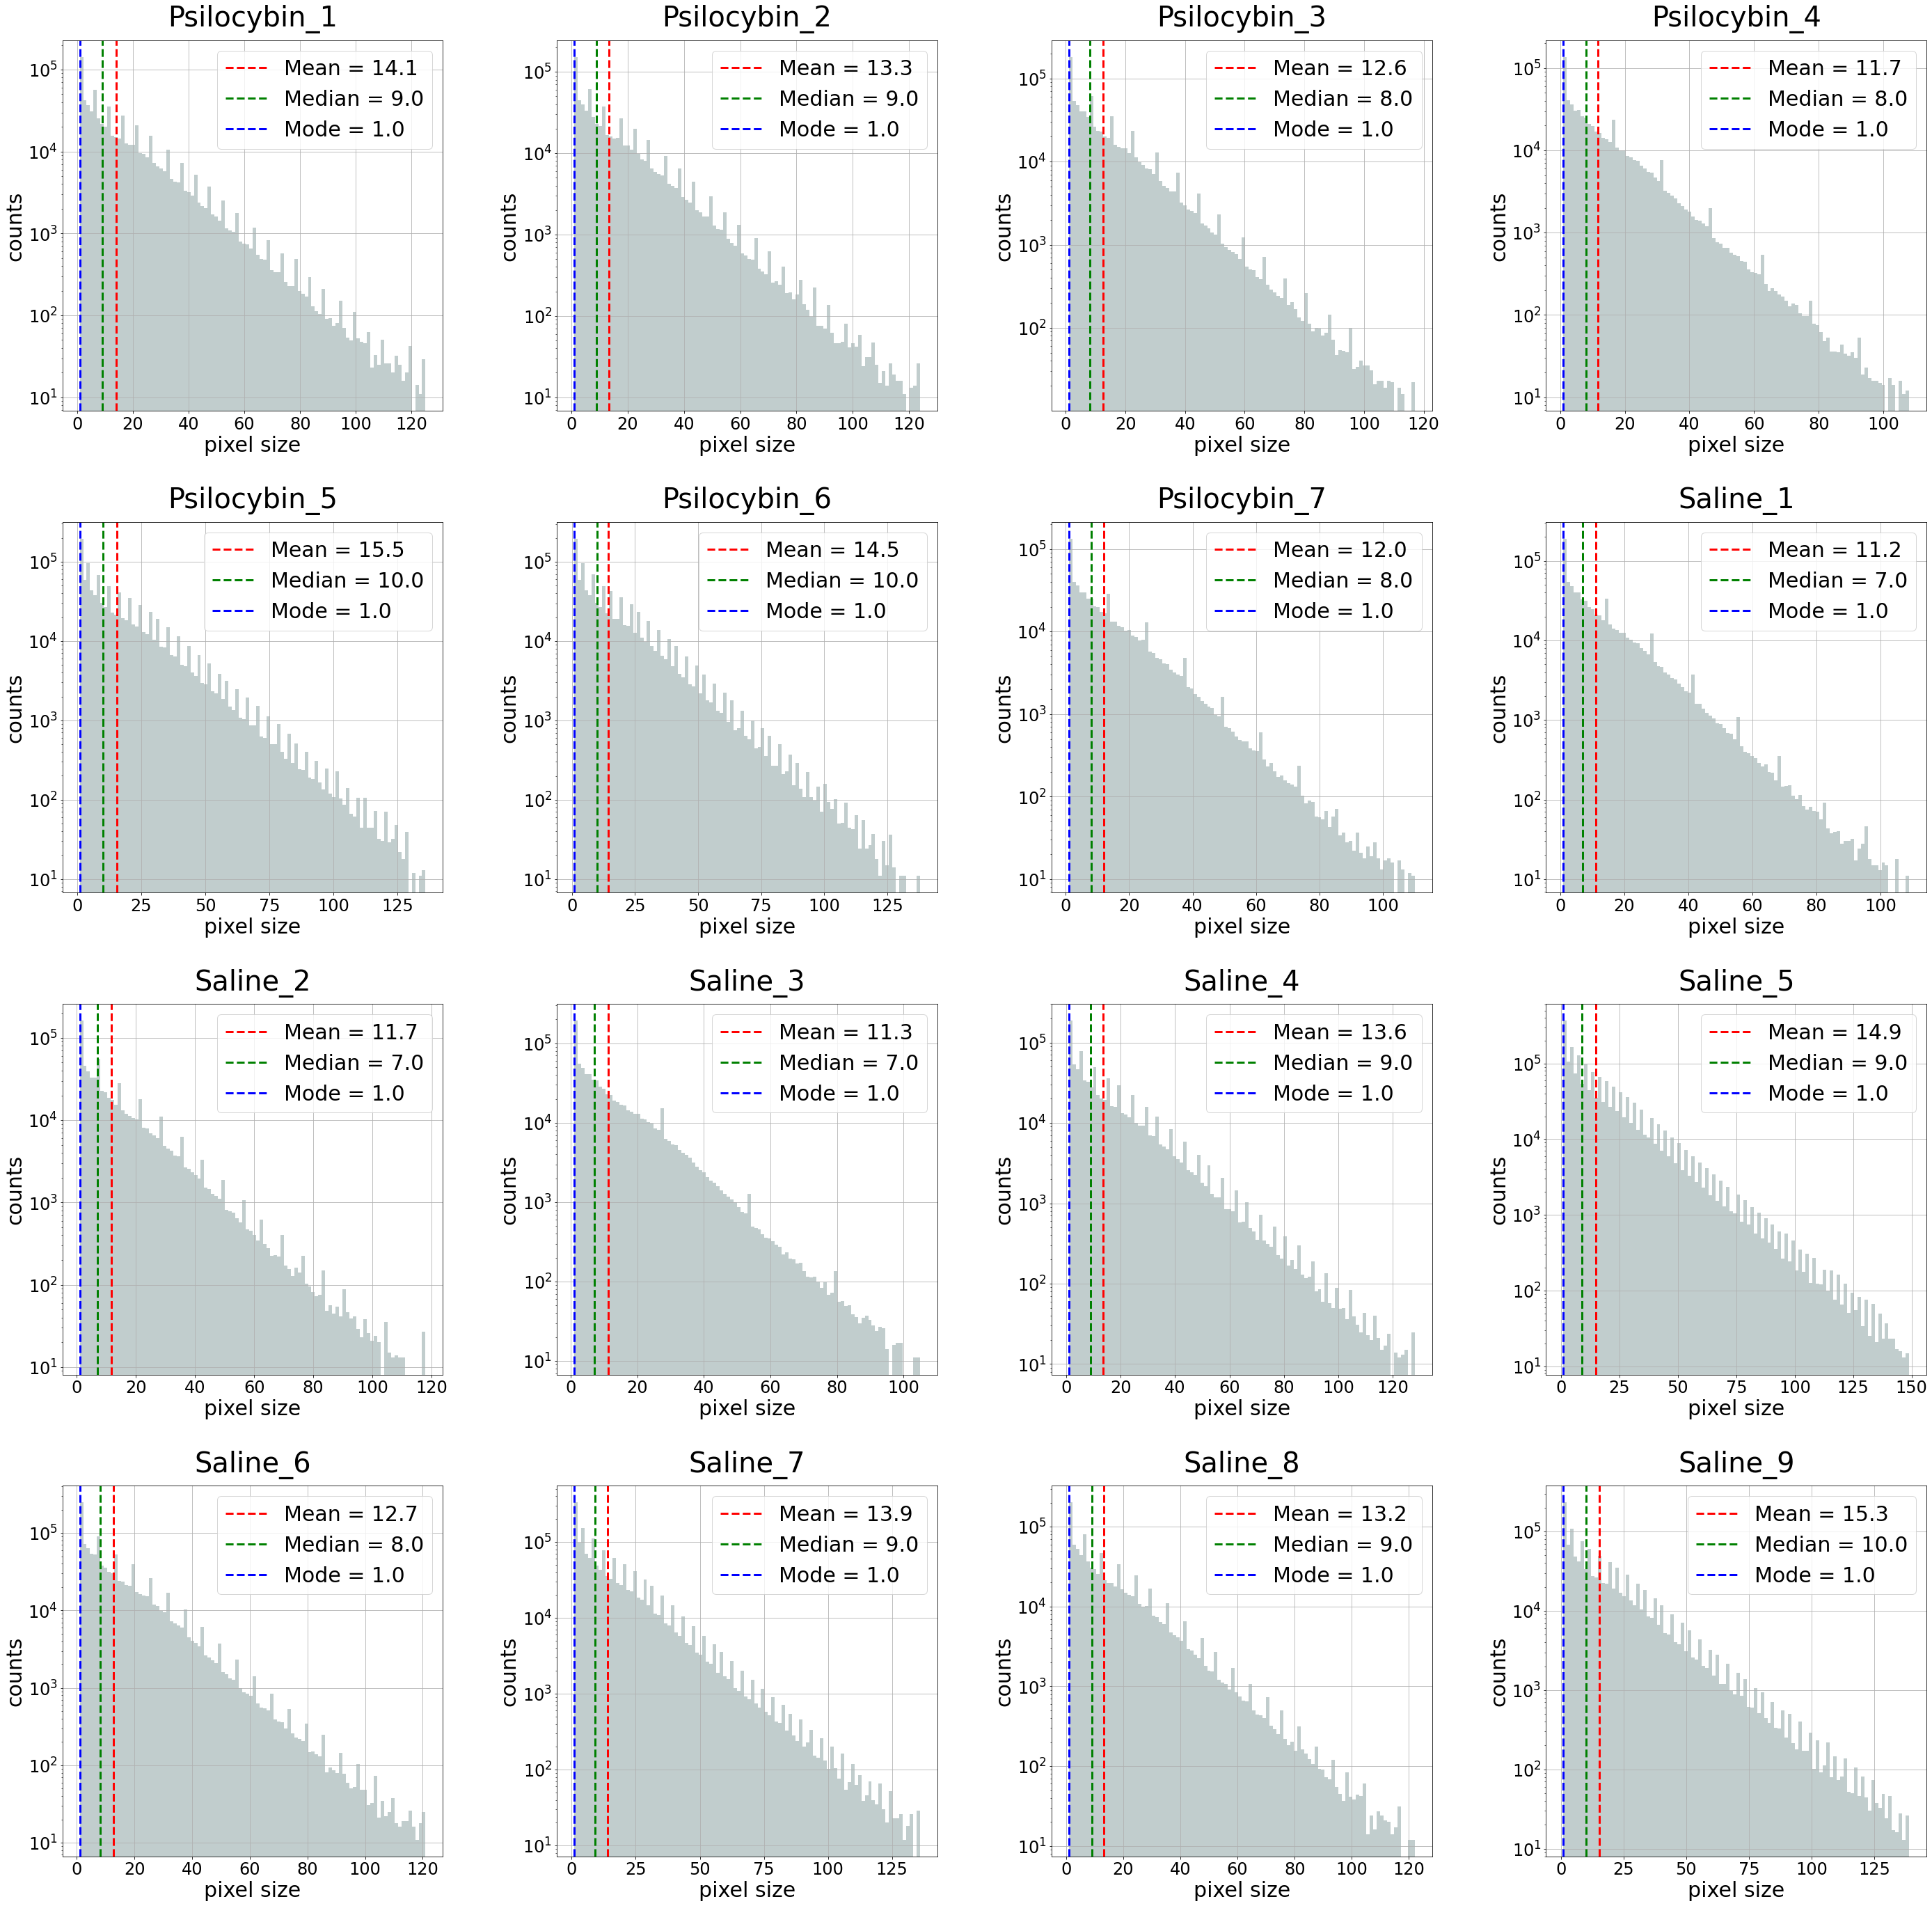

In [26]:
#plotting pixel histograms
# pixel_columns = pivoted_pixel_data.columns.values

fig, axes = plt.subplots(len(pivoted_pixel_data.columns)//4, 4, figsize=(48, 48))

i = 0
for triaxis in axes:
    for axis in triaxis:
        pivoted_pixel_data.hist(column = pivoted_pixel_data.columns[i], bins = 100, ax=axis, color='#C1CDCD')
        axis.set_title(pivoted_pixel_data.columns[i],pad=20, fontdict={'fontsize':40})
        axis.set_yscale('log')
        axis.set_ylabel('counts',fontdict={'fontsize':30})
        axis.set_xlabel('pixel size',fontdict={'fontsize':30})
        axis.tick_params(labelsize=24)
        mean = pivoted_pixel_data[pivoted_pixel_data.columns[i]].mean()
        mean = round(mean,1)
        median = pivoted_pixel_data[pivoted_pixel_data.columns[i]].median()
        mode = pivoted_pixel_data[pivoted_pixel_data.columns[i]].mode()
        mode = np.take(mode.values,0)

        axis.axvline(mean, color='r', linestyle='--', linewidth= 3)
        axis.axvline(median, color='g', linestyle='--', linewidth= 3)
        axis.axvline(mode, color='b', linestyle='--', linewidth= 3)
        axis.legend({'Mean = {}'.format(mean):mean,'Median = {}'.format(median):median,'Mode = {}'.format(mode):mode},prop={'size': 30})

        i = i+1
        

fig.patch.set_facecolor('white')
fig.savefig('pixel_histograms.png')

In [25]:
#Ending timming process
end = time.time()

# Printing how many files were processed and how much time the process took
files_processed = number_activity_files = number_files+ number_volume_files + number_volintissue_files
print(files_processed,' Files processed ')
print(' ')
print(' Execution time:', round((end - start),2), 'seconds') 

48  Files processed 
 
 Execution time: 67.85 seconds
